# 环境配置和模型导入

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras

Using TensorFlow backend.


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

#seed
np.random.seed(2017)
from keras.models import *
from keras.layers.convolutional import Conv2D
from keras.applications import *

In [3]:
model = load_model('my_model12.h5')

In [4]:
model.summary()
len(model.layers)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

135

In [11]:
index = os.path.join('.', 'driver_imgs_list.csv')
f = open(index, 'r')
lines = f.readlines()
class_list = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
error = []

for line in lines[1:100]:
    arr = line.strip().split(',')
    p = os.path.join('.', 'train', arr[1], arr[2])
    predictions = model.predict(np.expand_dims(get_im_cv2(p,299), axis=0))
    predictions = predictions[0]    
    pred_idx = np.argmax(predictions)
    #print (class_list[pred_idx], arr[1])
    if class_list[pred_idx] != arr[1]:
        error.append(arr[2])
        
print (error)

['img_66355.jpg', 'img_29321.jpg', 'img_99512.jpg']


# 读取图片并展示

In [6]:
# Load a preprocessed image
def get_im_cv2(path, img_size):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reduce size
    img = cv2.resize(img, (img_size, img_size))
    # normalization
    img /= 127.5
    img -= 1.
    #print (img[1:5, 1:5, 0])
    return img

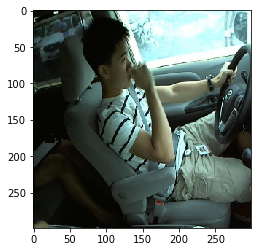

In [12]:
%matplotlib inline
path1 = os.path.join('.', 'train', 'c0', 'img_66355.jpg')

plt.imshow((get_im_cv2(path1, 299)+1)/2)

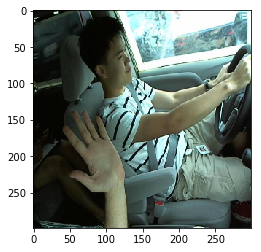

In [13]:
%matplotlib inline
path2 = os.path.join('.', 'train', 'c0', 'img_29321.jpg')

plt.imshow((get_im_cv2(path2, 299)+1)/2)

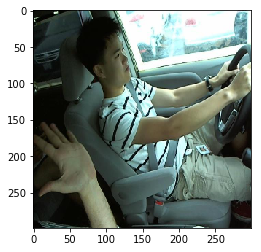

In [15]:
%matplotlib inline
path3 = os.path.join('.', 'train', 'c0', 'img_99512.jpg')

plt.imshow((get_im_cv2(path3, 299)+1)/2)

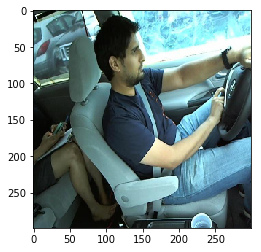

In [16]:
%matplotlib inline
path4 = os.path.join('.', 'train', 'c0', 'img_1078.jpg')

plt.imshow((get_im_cv2(path4, 299)+1)/2)

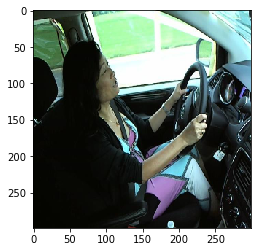

In [17]:
%matplotlib inline
path5 = os.path.join('.', 'train', 'c0', 'img_327.jpg')

plt.imshow((get_im_cv2(path5, 299)+1)/2)

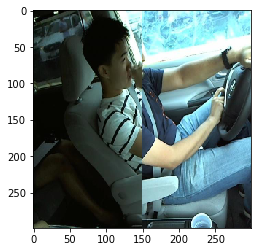

In [18]:
# concatenate two images
img = get_im_cv2(path1, 299)
img2 = get_im_cv2(path4, 299)
left = img[:, :150, :]
right = img2[:, 150:, :]
img = np.concatenate((left, right), axis=1)
%matplotlib inline
plt.imshow((img+1)/2)

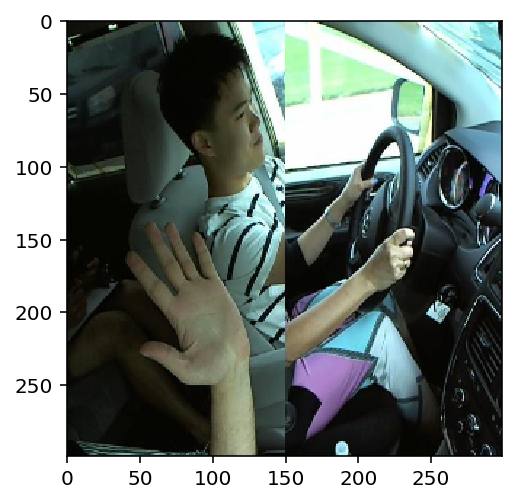

In [27]:
# concatenate two images
img = get_im_cv2(path2, 299)
img2 = get_im_cv2(path5, 299)
left = img[:, :150, :]
right = img2[:, 150:, :]
img = np.concatenate((left, right), axis=1)
%matplotlib inline
plt.imshow((img+1)/2)

# CAM可视化

In [19]:
# the model to get the feature map
model_cnn = Model(model.input, model.layers[131].output, name='xception')

# the model to get cam
inputs = Input((299, 299, 3))
x = inputs
x = model_cnn(x)
cam = Conv2D(10, 1, use_bias=False, name='cam')(x)
model_cam = Model(inputs, cam)

# set the weight of last layer
weights = model.layers[134].get_weights()[0]
#print (np.shape(weights))
model_cam.layers[-1].set_weights([weights.reshape((1,1,2048,10))])


In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_cam(image):
    status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]
    plt.figure()
    predictions = model.predict(np.expand_dims(image, axis=0))
    predictions = predictions[0]    
    pred_idx = np.argmax(predictions)
    pred = status[pred_idx]
    prediction = predictions[pred_idx]

    plt.title('Pred: %s %.2f%%' % (pred, prediction*100))
    
    cam = model_cam.predict(np.expand_dims(image, axis=0))
    cam = cam[0,:,:,pred_idx]
    cam -= cam.min()
    cam /= cam.max()
    cam = cv2.resize(cam, (299, 299))
    cam[cam<0] = 0
    cam[cam>1] = 1
    cam = np.uint8(255*cam)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    out = cv2.addWeighted(np.uint8((image+1)/2*255), 0.6, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out)

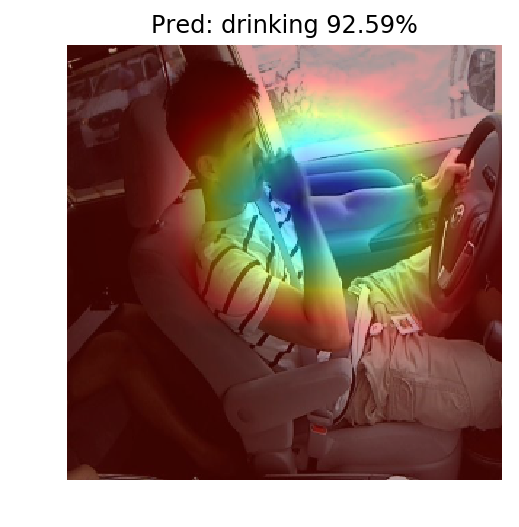

In [21]:
show_cam(get_im_cv2(path1, 299))

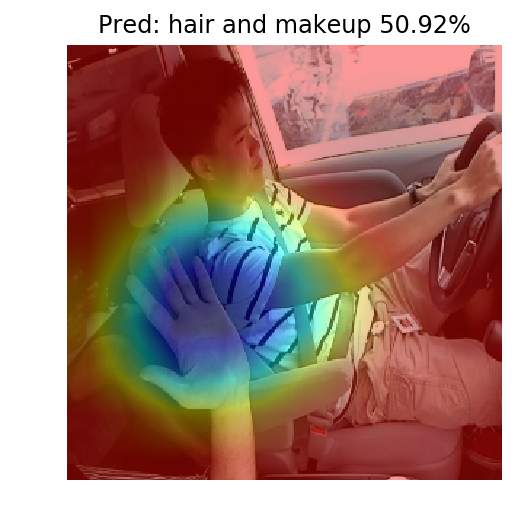

In [22]:
show_cam(get_im_cv2(path2, 299))

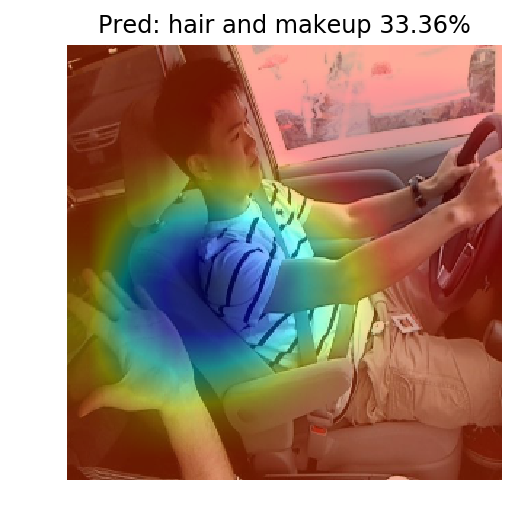

In [23]:
show_cam(get_im_cv2(path3, 299))

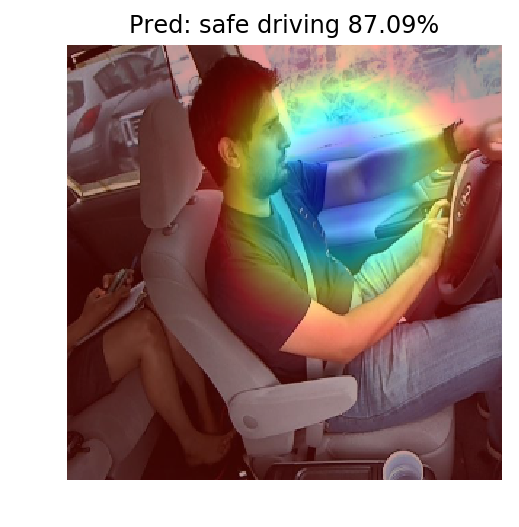

In [24]:
show_cam(get_im_cv2(path4, 299))

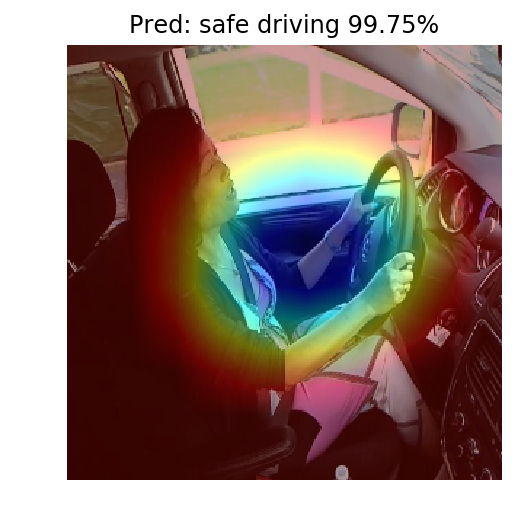

In [25]:
show_cam(get_im_cv2(path5, 299))

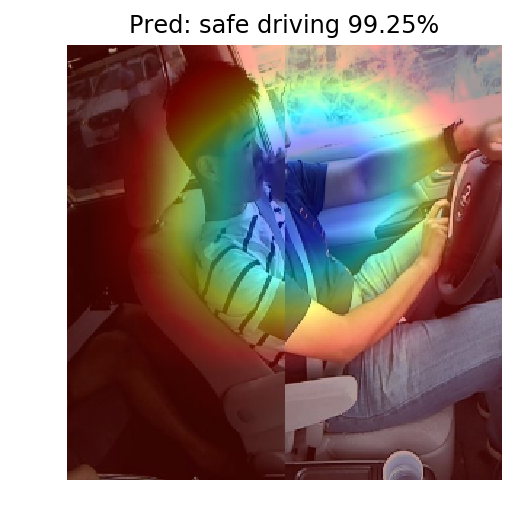

In [26]:
show_cam(img)

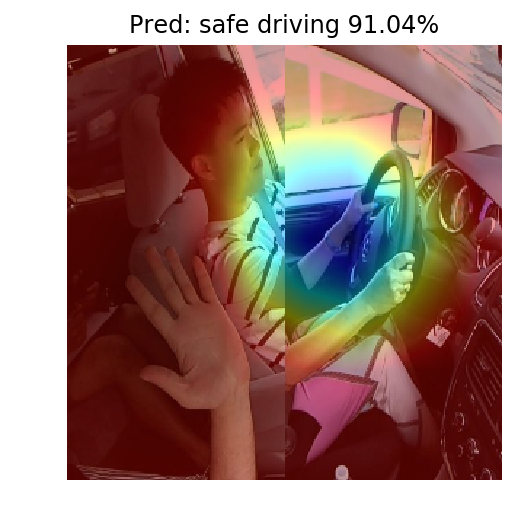

In [28]:
show_cam(img)